In [1]:
import numpy as np
import torch
import random

import matplotlib.pyplot as plt


import torch
from torch import nn, optim
from torch import load
from torch.nn import functional as F
from torch import autograd

from torchvision import datasets

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import time

import sys
from pathlib import Path

from numba import njit

import os

import gc

In [2]:
from easy_ntk import compute_NTK_CNN

In [3]:
experiment_base_path = '/rcfs/projects/task0_pmml/easy_ntk/experiments_data/12_9_binary_mnist/'

d1_path = os.path.join(experiment_base_path,'d1_component')
d2_path = os.path.join(experiment_base_path,'d2_component')
d3_path = os.path.join(experiment_base_path,'d3_component')
d4_path = os.path.join(experiment_base_path,'d4_component')

ntk_path = os.path.join(experiment_base_path,'ntk')

In [4]:
SEED = 0
N_EPOCHS=1_000_000
LR=1e-4

In [5]:
def activation(x):
    return torch.tanh(x)

def d_activationt(x):
    return torch.cosh(x)**-2

In [6]:
def NTK_weights(m):
    if isinstance(m, nn.Linear):
        print(m.weight.shape)
        nn.init.normal_(m.weight.data)#/m.weight.shape[0]
        if m.bias != None:
            nn.init.normal_(m.bias.data)#/m.weight.shape[0]
    if isinstance(m, nn.Conv2d):
        print(m.weight.shape)
        nn.init.normal_(m.weight.data)#/m.weight.shape[0]
        if m.bias != None:
            nn.init.normal_(m.bias.data)#/m.weight.shape[0]

In [7]:
class FC(torch.nn.Module):
    '''
    simple network for test cases
    
    
    It seems like bias vectors aren't trivially added.
    '''
    def __init__(self,):
        super(FC, self).__init__()
        #input size=(N,784)
        self.d1 = torch.nn.Linear(784,50,bias=False)

        self.d2 = torch.nn.Linear(50,50,bias=False)
        
        self.d3 = torch.nn.Linear(50,50,bias=False)
        
        self.d4 = torch.nn.Linear(50,1,bias=False)
        
    def forward(self, x0):
        x1 = 1/np.sqrt(50) * activation(self.d1(x0))
        x2 = 1/np.sqrt(50) * activation(self.d2(x1))
        x3 = 1/np.sqrt(50) * activation(self.d3(x2))
        x4 = self.d4(x3)
        return x4, x3, x2, x1, x0

In [8]:
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
device='cuda'

model = FC()
model.to(device)
model.apply(NTK_weights)

torch.Size([50, 784])
torch.Size([50, 50])
torch.Size([50, 50])
torch.Size([1, 50])


FC(
  (d1): Linear(in_features=784, out_features=50, bias=False)
  (d2): Linear(in_features=50, out_features=50, bias=False)
  (d3): Linear(in_features=50, out_features=50, bias=False)
  (d4): Linear(in_features=50, out_features=1, bias=False)
)

In [9]:
train_data = datasets.MNIST(
    root = '/people/enge625/NOTEBOOKS/',
    train = True,                          
    download = False,            
)


test_data = datasets.MNIST(
    root = '/people/enge625/NOTEBOOKS/', 
    train = False, 
    download=False,
)

In [10]:
train_x = train_data.data
test_x = test_data.data

train_y = train_data.targets
test_y = test_data.targets

train_mask = torch.logical_or(train_y==6,train_y==9)
test_mask = torch.logical_or(test_y==6,test_y==9)

train_x = train_x[train_mask]
train_y = train_y[train_mask]

test_x = test_x[test_mask]
test_y = test_y[test_mask]

train_x = train_x/255.0
test_x = test_x/255.0

train_y[train_y==6] = 0
train_y[train_y==9] = 1

test_y[test_y==6] = 0
test_y[test_y==9] = 1

train_x = train_x.reshape(-1,784)
test_x = test_x.reshape(-1,784)

train_y = train_y.float()
test_y = test_y.float()

mask = torch.zeros((11867),dtype=torch.bool)
mask[:] = True

train_x=train_x[mask]
train_y=train_y[mask]

train_x = train_x.to('cuda')
train_y = train_y.to('cuda')
#test_x = test_x.to('cuda')
#test_y = train_y.to('cuda')

#we don't need a dataloader because we will just implement vanilla gradient descent

In [11]:
model.d1.bias

In [12]:
criterion = torch.nn.BCEWithLogitsLoss()

In [13]:
def forward(model, x_test):
    x_4, x_3, x_2, x_1, x_0 = model(x_test)

    #These need to be numpy
    Ws = []
    Ws.append(model.d1.weight.detach())
    Ws.append(model.d2.weight.detach())
    Ws.append(model.d3.weight.detach())
    Ws.append(model.d4.weight.detach())

    #Kernel Matrices, Need to be numpy
    Ks = []
    Ks.append(torch.tensor([0.0],dtype=torch.float32)) 
    Ks.append(torch.tensor([0.0],dtype=torch.float32))
    Ks.append(torch.tensor([0.0],dtype=torch.float32))
    Ks.append(torch.tensor([0.0],dtype=torch.float32))


    Xs = [] # Xs are shape (output x #DP) ; however, typical python notation is reversed, so we take transpose here
    Xs.append(x_0.T.detach())
    Xs.append(x_1.T.detach())
    Xs.append(x_2.T.detach())
    Xs.append(x_3.T.detach())

    #This is used to create arrays-- needs to be integer list to play nice with compilers
    d_int = []
    d_int.append(50)
    d_int.append(50)
    d_int.append(50)
    d_int.append(50)

    d_array = [] #this is for the NTK formulation, 
    #ds_array.append(torch.tensor([1.0],dtype=torch.float32).to(device)) #first element is a spacer, could be anything.

    d_array.append(torch.tensor([50.0],dtype=torch.float32).to(device)) 
    d_array.append(torch.tensor([50.0],dtype=torch.float32).to(device)) 
    d_array.append(torch.tensor([50.0],dtype=torch.float32).to(device))
    d_array.append(torch.tensor([50.0],dtype=torch.float32).to(device))
    d_array.append(torch.tensor([50.0],dtype=torch.float32).to(device))

    filters = []
    filters.append(0)
    filters.append(0)
    filters.append(0)
    filters.append(0)

    padding = []
    padding.append(0)
    padding.append(0)
    padding.append(0)
    padding.append(0)

    strides = []
    strides.append(0)
    strides.append(0)
    strides.append(0)
    strides.append(0)

    layers=[model.d1,
            model.d2,
            model.d3,
            model.d4,
           ]
    
    #Ws Ks Xs d_int d_array strides padding layers d_activationt, device="cuda"
    return x_4[:,0], {'Ws':Ws, 'Ks':Ks, 'Xs':Xs, 'd_int':d_int, 'd_array':d_array, 'strides':strides, 'padding':padding, 'layers':layers, 'd_activationt':d_activationt, 'device':'cuda'}

In [14]:
def visualize_spectrum(NTK_component,epoch,save_str):
    '''
    takes a numpy array and saves the image to save_str
    '''
    fig = plt.figure(figsize=(8,8))
    plt.hist(torch.linalg.eigvalsh(NTK_component).detach().cpu().numpy(), bins=np.logspace(-14,4,100,10.0))
    plt.xscale('log')
    plt.xlabel('eigenvalue')
    plt.title('{} eigenvalue spectrum: {}'.format(save_str,str(epoch).zfill(5)))
    #plt.savefig(os.path.join(experiment_base_path,'images',save_str,str(epoch).zfill(5)+'.png'))
    #plt.close()
    plt.show()
    
def visualize_spectrum_linear(NTK_component,epoch,save_str):
    '''
    takes a numpy array and saves the image to save_str
    '''
    fig = plt.figure(figsize=(8,8))
    plt.hist(torch.linalg.eigvalsh(NTK_component).detach().cpu().numpy(), bins=np.linspace(1e-14,1e4,100,10.0))
    plt.xlabel('eigenvalue')
    plt.title('{} eigenvalue spectrum: {}'.format(save_str,str(epoch).zfill(5)))
    #plt.savefig(os.path.join(experiment_base_path,'images',save_str,str(epoch).zfill(5)+'.png'))
    #plt.close()
    plt.show()
    

In [15]:
from tqdm import tqdm

In [16]:
losses=[]
accuracies=[]

step=0
#while True:
for step in tqdm(range(1,N_EPOCHS+1)):
    now = time.time()
    
    model.zero_grad()
    
    output, params = forward(model, train_x)
    
    if step==1:
        components_init = compute_NTK_CNN(**params)
        #NTK_init = torch.sum(torch.stack(components),dim=0)
        #del components[:]
        #del components
        #torch.cuda.empty_cache()
    
    loss = criterion(output,train_y)
    loss.backward()
    
    losses.append(loss.item())
        
    
    with torch.no_grad():
        for name,W in model.named_parameters():
            W-= LR * W.grad
            
    predictions = torch.round(torch.sigmoid(output))
    acc = torch.sum(predictions==train_y)
    accuracies.append(acc.detach().cpu().numpy()/len(train_y))

    if (losses[-1] < 1e-5) or accuracies[-1]==1.0 or step==N_EPOCHS:
        components_end = compute_NTK_CNN(**params)
        #NTK_end = torch.sum(torch.stack(components),dim=0)
        #del components[:]
        #del components
        #torch.cuda.empty_cache()
        break
    #step+=1
    
    

100%|████████████████████████████████████████████████████████████████████████▉| 999999/1000000 [31:37<00:00, 527.09it/s]


In [17]:
step

1000000

In [18]:
accuracies[-1]

0.9732872672115952

In [19]:
#np.save(os.path.join(experiment_base_path,'loss'),np.array(losses))
#np.save(os.path.join(experiment_base_path,'accuracy'),np.array(accuracies))

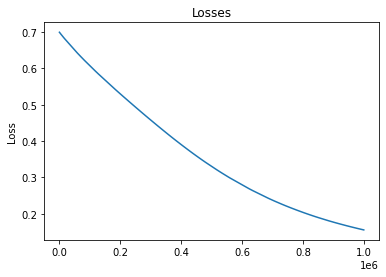

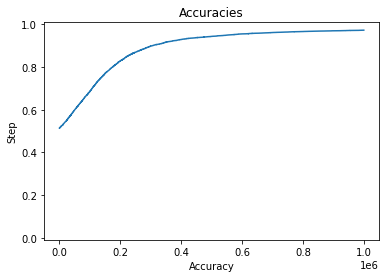

0.1555199921131134


In [20]:
plt.plot(losses)
plt.title('Losses')
plt.ylabel('Loss')
plt.show() 

plt.plot(accuracies,label='train')
plt.title('Accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Step')
plt.ylim(-0.01,1.01)
plt.show()

print(losses[-1])

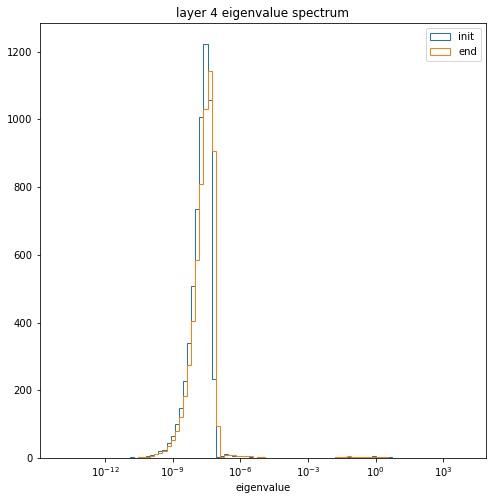

In [21]:
fig = plt.figure(figsize=(8,8))
plt.hist(torch.linalg.eigvalsh(components_init[0]).detach().cpu().numpy(), bins=np.logspace(-14,4,100,10.0),histtype='step',label='init')
plt.hist(torch.linalg.eigvalsh(components_end[0]).detach().cpu().numpy(), bins=np.logspace(-14,4,100,10.0),histtype='step',label='end')
plt.xscale('log')
plt.xlabel('eigenvalue')
plt.legend()
plt.title('{} eigenvalue spectrum'.format('layer 4'))
plt.show()

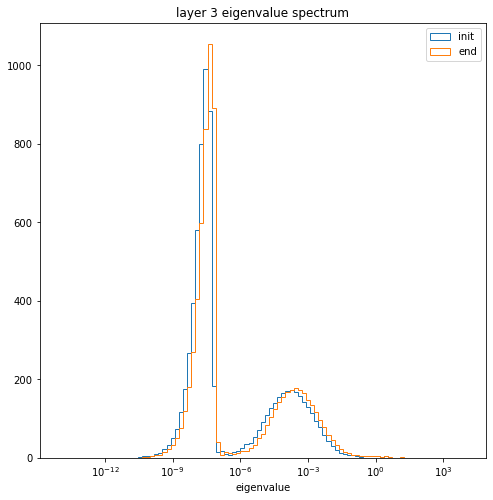

In [22]:
fig = plt.figure(figsize=(8,8))
plt.hist(torch.linalg.eigvalsh(components_init[1]).detach().cpu().numpy(), bins=np.logspace(-14,4,100,10.0),histtype='step',label='init')
plt.hist(torch.linalg.eigvalsh(components_end[1]).detach().cpu().numpy(), bins=np.logspace(-14,4,100,10.0),histtype='step',label='end')
plt.xscale('log')
plt.xlabel('eigenvalue')
plt.legend()
plt.title('{} eigenvalue spectrum'.format('layer 3'))
plt.show()

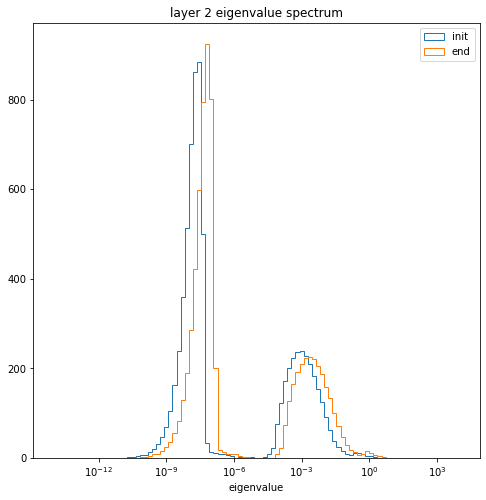

In [23]:
fig = plt.figure(figsize=(8,8))
plt.hist(torch.linalg.eigvalsh(components_init[2]).detach().cpu().numpy(), bins=np.logspace(-14,4,100,10.0),histtype='step',label='init')
plt.hist(torch.linalg.eigvalsh(components_end[2]).detach().cpu().numpy(), bins=np.logspace(-14,4,100,10.0),histtype='step',label='end')
plt.xscale('log')
plt.xlabel('eigenvalue')
plt.legend()
plt.title('{} eigenvalue spectrum'.format('layer 2'))
plt.show()

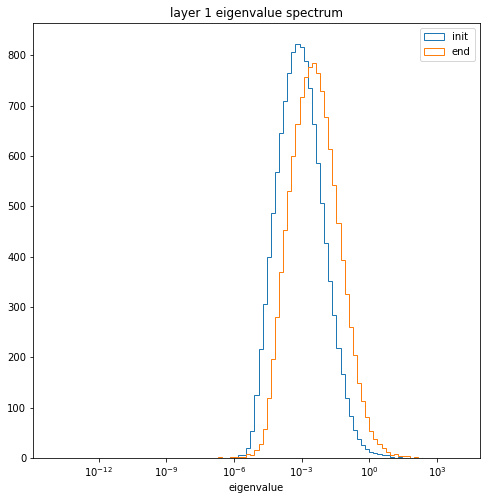

In [24]:
fig = plt.figure(figsize=(8,8))
plt.hist(torch.linalg.eigvalsh(components_init[3]).detach().cpu().numpy(), bins=np.logspace(-14,4,100,10.0),histtype='step',label='init')
plt.hist(torch.linalg.eigvalsh(components_end[3]).detach().cpu().numpy(), bins=np.logspace(-14,4,100,10.0),histtype='step',label='end')
plt.xscale('log')
plt.xlabel('eigenvalue')
plt.legend()
plt.title('{} eigenvalue spectrum'.format('layer 1'))
plt.show()

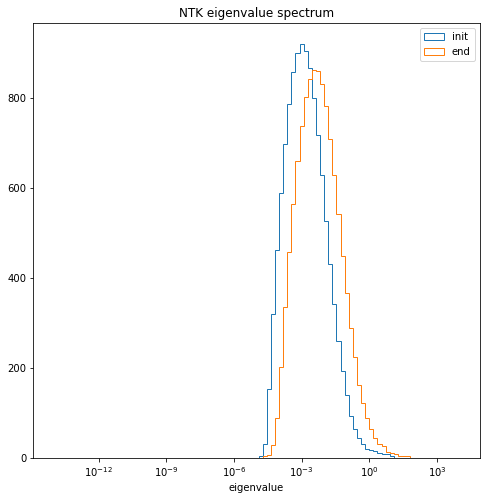

In [25]:
fig = plt.figure(figsize=(8,8))
plt.hist(torch.linalg.eigvalsh(torch.sum(torch.stack(components_init),dim=0)).detach().cpu().numpy(), bins=np.logspace(-14,4,100,10.0),histtype='step',label='init')
plt.hist(torch.linalg.eigvalsh(torch.sum(torch.stack(components_end),dim=0)).detach().cpu().numpy(), bins=np.logspace(-14,4,100,10.0),histtype='step',label='end')
plt.xscale('log')
plt.xlabel('eigenvalue')
plt.legend()
plt.title('{} eigenvalue spectrum'.format('NTK'))
plt.show()

In [26]:
step

1000000

In [27]:
L2 = torch.sqrt(torch.sum(torch.square(torch.sum(torch.stack(components_init),dim=0) - torch.sum(torch.stack(components_end),dim=0))))
print(L2)

tensor(179.2429, device='cuda:0')


In [28]:
np.save('./NTK_init.npy',torch.sum(torch.stack(components_init),dim=0).detach().cpu().numpy())
np.save('./NTK_end.npy',torch.sum(torch.stack(components_end),dim=0).detach().cpu().numpy())